# 1. Setup and Moving Data to MySQL Database
The databse has the following attributes:
- User: de300_u1
- Password: de300u1springaccess
- Host: sql_container
- Database: heart_disease

In [354]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import re

## 1.1 Initial Data Cleaning

In [355]:
# Database connection parameters
user = 'de300_u1'  # Your database username
password = 'de300u1springaccess'  # Your database password
host = 'sql_container'  # Database host (Docker container name if on the same Docker network)
database = 'heart_disease'  # Database name
table_name = 'heart_disease_data'  # Name of the table to create/insert data into
table_name_cleaned = 'heart_disease_data_cleaned'  # Name of the cleaned table

# Create the SQLAlchemy engine
engine = create_engine(f'mysql+mysqlconnector://{user}:{password}@{host}/{database}')

# Read data from CSV file
data = pd.read_csv('heart_disease.csv', sep=',', engine='python')

In [356]:
# Function to check if any value in a row contains spaces or is non-numeric
def is_invalid(row):
    for item in row:
        if isinstance(item, str) and (' ' in item or not item.replace('.', '', 1).isdigit()):
            return True
    return False

# Filter out rows with invalid data
data = data[~data.apply(is_invalid, axis=1)]

# Q1: WRITE DATA TO MYSQL DATABASE
data.to_sql(name=table_name, con=engine, if_exists='replace', index=False)

print(f"Selected columns from 'heart_disease.csv' have been successfully loaded into the '{table_name}' table in the '{database}' database.")

### Retrive data from the database
data = pd.read_sql(f'SELECT * FROM {table_name}', engine)

### Remove columns if more than 10% of the values are missing
threshold = len(data) * 0.90 # Number of non-na values
data = data.dropna(thresh=threshold, axis=1)

print("All columns in the 'heart_disease.csv' file:")
print("Number of columsn: ", len(data.columns))
print(data.columns)

# Convert all object type columns to float64
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].astype('float64')


Selected columns from 'heart_disease.csv' have been successfully loaded into the 'heart_disease_data' table in the 'heart_disease' database.
All columns in the 'heart_disease.csv' file:
Number of columsn:  28
Index(['age', 'sex', 'cp', 'trestbps', 'htn', 'chol', 'restecg', 'ekgmo',
       'ekgday(day', 'ekgyr', 'dig', 'prop', 'nitr', 'pro', 'thaldur',
       'thalach', 'thalrest', 'tpeakbps', 'tpeakbpd', 'dummy', 'trestbpd',
       'exang', 'xhypo', 'oldpeak', 'cmo', 'cday', 'cyr', 'target'],
      dtype='object')


## 1.2 Initial Data Cleaning Discusssion
Reading on some material on medical data collection, the commonly agreed on amount of missing data that is tolerable is usually 5% - 10%, any more than that the data is considered bias. While in some other fields a higher percentage can be tolerated (less or eqaul to 30% of missing data), in a domain where accurate data (both numerical and categorical) is essential, a low percentage of missing data will help to get accurate results.

However, given the low amount of data already in this dataset (around 1000 entries), 10% was selected to avoid removing too many data points.

### Additional Feature Explanations
htn - hypertension

dummy - placebo

xhypo - Hypoglycemia


In [357]:
# Identifying columns with any NA values
columns_with_na = data.columns[data.isna().any()].tolist()
print(f"Columns containing NA values: {columns_with_na}")

# Counting rows with at least one NA
na_row_count = data.isna().any(axis=1).sum()
print(f"Number of rows containing at least one NA value: {na_row_count}")

Columns containing NA values: ['age', 'sex', 'cp', 'trestbps', 'htn', 'chol', 'restecg', 'ekgmo', 'ekgday(day', 'ekgyr', 'dig', 'prop', 'nitr', 'pro', 'thaldur', 'thalach', 'thalrest', 'tpeakbps', 'tpeakbpd', 'dummy', 'trestbpd', 'exang', 'xhypo', 'oldpeak', 'cmo', 'cday', 'cyr', 'target']
Number of rows containing at least one NA value: 158


### 1.3 Further Data Cleaning and Missing Value Imputation
To address these na values, some columns will be treated to imputations while others will be ignores, below are the action details. For imputation methods, **mode** will be the selected method as the number of missing values is not overwhelming per column, as that has been taken care of tby the 90% good values threshold above.

**Numerical Features**
_age, trestbps, chol, thalach, oldpeak, tpeakbps, tpeakbpd, trestbpd, thaldur_

These data points will be imputed using the **mode** of the remaining data, since this will preserve the statistical properties of the datasets. The mean/median can also be used but mean is selected here.

**Categorical Features**
_cp, restecg_

For most of these features they will be imputed with the **mode** of the data in that column, with the same reasoning before. However, upon research _cp (chest pain type)_ is a effective predictor for heart disease. Because of its importance, rows with na values in the _cp_ column will be removed.

**Binary Features**
_sex, htn, dig, prop, nitr, pro, exang, xhypo, dymmy_

These features will be treated to the same **mode** imputation as above to maintain method consistency.

**Dates**
_ekgmo, ekgday, ekgyr, cmo, cday, cyr_

Upon research, it seems that dates may be less of a predictor compared to other data types above. Imputing this type of data is inconvenient and given its lesser predictive value, these columns will be removed from the dataset.

In [358]:
# Group together numerical, categorical, and binary feature column names
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'tpeakbps', 'trestbpd', 'tpeakbpd', 'thaldur', 'thalrest']
categorical_features = ['restecg']
binary_features = ['sex', 'htn', 'dig', 'prop', 'nitr', 'pro', 'exang', 'xhypo', 'dummy']

mode_features = numerical_features + categorical_features + binary_features

# Remove temporal features
data.drop(columns=['ekgmo', 'ekgday(day', 'ekgyr', 'cmo', 'cday', 'cyr'], inplace=True)

# Impute missing values using mode for remaining columns
for column in mode_features:
    mode_value = data[column].mode().iloc[0]  # Get the mode and handle potential multiple modes
    print(f"Imputing mode value for column '{column}': {mode_value}")
    data[column].fillna(mode_value, inplace=True)
    
# Remove any remaining rows with NA values
data.dropna(inplace=True)
    
# Re-evaluate number of rows and columns with at least one NA
# Identifying columns with any NA values
columns_with_na = data.columns[data.isna().any()].tolist()
print(f"Columns containing NA values: {columns_with_na}")

# Counting rows with at least one NA
na_row_count = data.isna().any(axis=1).sum()
print(f"Number of rows containing at least one NA value: {na_row_count}")

Imputing mode value for column 'age': 54.0
Imputing mode value for column 'trestbps': 120.0
Imputing mode value for column 'chol': 0.0
Imputing mode value for column 'thalach': 150.0
Imputing mode value for column 'oldpeak': 0.0
Imputing mode value for column 'tpeakbps': 180.0
Imputing mode value for column 'trestbpd': 80.0
Imputing mode value for column 'tpeakbpd': 80.0
Imputing mode value for column 'thaldur': 9.0
Imputing mode value for column 'thalrest': 70.0
Imputing mode value for column 'restecg': 0.0
Imputing mode value for column 'sex': 1.0
Imputing mode value for column 'htn': 0.0
Imputing mode value for column 'dig': 0.0
Imputing mode value for column 'prop': 0.0
Imputing mode value for column 'nitr': 0.0
Imputing mode value for column 'pro': 0.0
Imputing mode value for column 'exang': 0.0
Imputing mode value for column 'xhypo': 0.0
Imputing mode value for column 'dummy': 120.0
Columns containing NA values: []
Number of rows containing at least one NA value: 0


# 2. Identifying Outliers and Calculating Stats

In [359]:
# For each of the numerical features column, calculate the mean, median, and standard deviation
# Calculate summary statistics and discard outliers

stats = {}

print("Number of rows before removing outliers:", len(data))

for feature in numerical_features:
    mean = data[feature].mean()
    median = data[feature].median()
    std_dev = data[feature].std()
    mode = data[feature].mode().iloc[0]
    variance = data[feature].var()
    max_val = data[feature].max()
    min_val = data[feature].min()
    
    # Add the calculated statistics to the dictionary
    stats[feature] = {
        'mean': mean,
        'median': median,
        'std_dev': std_dev,
        'mode': mode,
        'variance': variance,
        'max': max_val,
        'min': min_val
    }

    # Discard rows where the feature value is more than 3 standard deviations from the mean
    len_before = len(data)
    data = data[np.abs(data[feature] - mean) <= 3 * std_dev]
    len_after = len(data)
    
    if len_before != len_after:
        print(f"Outliers removed for feature '{feature}': {len_before - len_after} rows")
    
print("Number of rows after removing outliers:", len(data))

Number of rows before removing outliers: 899
Outliers removed for feature 'trestbps': 8 rows
Outliers removed for feature 'chol': 2 rows
Outliers removed for feature 'thalach': 1 rows
Outliers removed for feature 'oldpeak': 12 rows
Outliers removed for feature 'tpeakbps': 3 rows
Outliers removed for feature 'trestbpd': 2 rows
Outliers removed for feature 'tpeakbpd': 6 rows
Outliers removed for feature 'thaldur': 8 rows
Outliers removed for feature 'thalrest': 10 rows
Number of rows after removing outliers: 847


## 2.1 Outlier Detection Discussion
When detecting outliers, any data point outside of 3 standard deviations are excluded. As explaind in class, it is common for an outlier to be defined as outside of the boundary of 2 or 3 standar deviations (95% or 99.7% of data respectively). Using this way of excluding data points is also a common industry practice. However, given the limited data points we have, a standard deviation of 3 will remove any extremties, while maintaining the bulk of the limited data for accurate analysis later.

Since there are not many outliers, they are simply removed instead of replaced with any aggregate value to avoid creating misleading data.

In [360]:
# Print out statistics for each numerical feature, with each column being a newline
# Statistics of one column will be displayed on one line
# Statistics are mean, median, standard deviation, mode, and variance
print("Summary statistics for numerical features:")
for feature, values in stats.items():
    print(f"{feature:<10}: Mean: {values['mean']:.2f}, Max: {values['max']:.2f}, Min: {values['min']:.2f}, Median: {values['median']:.2f}, Std Dev: {values['std_dev']:.2f}, Mode: {values['mode']:.2f}, Variance: {values['variance']:.2f}")

Summary statistics for numerical features:
age       : Mean: 53.48, Max: 77.00, Min: 28.00, Median: 54.00, Std Dev: 9.44, Mode: 54.00, Variance: 89.04
trestbps  : Mean: 131.31, Max: 200.00, Min: 0.00, Median: 130.00, Std Dev: 18.75, Mode: 120.00, Variance: 351.66
chol      : Mean: 192.40, Max: 603.00, Min: 0.00, Median: 222.00, Std Dev: 115.45, Mode: 0.00, Variance: 13328.04
thalach   : Mean: 138.08, Max: 202.00, Min: 60.00, Median: 140.00, Std Dev: 25.26, Mode: 150.00, Variance: 638.15
oldpeak   : Mean: 0.81, Max: 6.20, Min: -2.60, Median: 0.20, Std Dev: 1.06, Mode: 0.00, Variance: 1.13
tpeakbps  : Mean: 172.28, Max: 240.00, Min: 84.00, Median: 174.00, Std Dev: 24.98, Mode: 180.00, Variance: 624.22
trestbpd  : Mean: 83.22, Max: 110.00, Min: 50.00, Median: 80.00, Std Dev: 9.43, Mode: 80.00, Variance: 88.86
tpeakbpd  : Mean: 86.95, Max: 134.00, Min: 11.00, Median: 85.00, Std Dev: 14.24, Mode: 80.00, Variance: 202.77
thaldur   : Mean: 8.74, Max: 24.00, Min: 1.00, Median: 9.00, Std Dev: 3

## 2.2 Statistical Analysis
From online research of typical medical data ranges, the typical ranges of these features are as follows:

| Feature                                               | Common Range          |
|-------------------------------------------------------|-----------------------|
| Age                                                   | 0 - 100               |
| Trestbps (Resting Blood Pressure - systolic)          | 90 - 140 mm Hg        |
| Chol (Serum Cholesterol)                              | 120 - 240 mg/dL       |
| Thalach (Maximum Heart Rate Achieved)                 | 60 - 200 bpm          |
| Oldpeak (ST Depression Induced by Exercise)           | 0 - 6 mm              |
| Tpeakbps (Peak Exercise Blood Pressure - systolic)    | 120 - 210 mm Hg       |
| Trestbpd (Resting Blood Pressure - diastolic)         | 60 - 90 mm Hg         |
| Tpeakbpd (Peak Exercise Blood Pressure - diastolic)   | 60 - 100 mm Hg        |
| Thaldur (Duration of Exercise Test in Minutes)        | 3 - 15 minutes        |
| Thalrest (Heart Rate at Rest)                         | 50 - 100 bpm          |

With these data ranges, it can be seen that each feature at least have some data. However some may not have their majority of data in these ranges. As a sanity check, it seems these features do possess reasonable data points that do not againstt common medical understanding. For a more accurate understanding of the tail and skewness of the data, kutosis and skewness needs to be analyzed. 

In [361]:
# Kurtosis and skewness for each numerical feature
print("Kurtosis and skewness for numerical features:")
for feature in numerical_features:
    kurtosis = data[feature].kurtosis()
    skewness = data[feature].skew()
    print(f"{feature:<10}: Kurtosis: {kurtosis:.2f}, Skewness: {skewness:.2f}")

Kurtosis and skewness for numerical features:
age       : Kurtosis: -0.41, Skewness: -0.14
trestbps  : Kurtosis: 0.21, Skewness: 0.55
chol      : Kurtosis: -0.54, Skewness: -0.60
thalach   : Kurtosis: -0.43, Skewness: -0.27
oldpeak   : Kurtosis: -0.11, Skewness: 0.88
tpeakbps  : Kurtosis: 0.20, Skewness: 0.08
trestbpd  : Kurtosis: 0.10, Skewness: 0.18
tpeakbpd  : Kurtosis: -0.25, Skewness: 0.26
thaldur   : Kurtosis: 0.71, Skewness: 0.64
thalrest  : Kurtosis: -0.02, Skewness: 0.42


## 2.3 Kurtosis and Skewness Calculations
The commonly accepted range for kurtosis is between -1 and 1, and the commonly accepted range for skewness is also between -1 and 1. As seen above, all of the numerical data features that are being used are within the ranges, for both kurtosis and skewness. This observation indicates that these numerical data features are symmetrical and has moderate to little tailedness as kurtosis is within range (similar to a normal distribution). As these features are all within the ranges, no transformations is necessary to further normalize/transform the data.

If the data were to exceed the range for kurtosis, winsorizing techniques can be used. If the data were to exceed the range for skewness, log or square root transformations can be used.

# 3. Transform Categorical Features

In [362]:
# Transform the categorical features into one-hot encoded columns
data = pd.get_dummies(data, columns=categorical_features)

print("Data after one-hot encoding of categorical features:")
print(data.head())

Data after one-hot encoding of categorical features:
    age  sex   cp  trestbps  htn   chol  dig  prop  nitr  pro  ...  tpeakbpd  \
0  63.0  1.0  1.0     145.0  1.0  233.0  0.0   0.0   0.0  0.0  ...      90.0   
1  67.0  1.0  4.0     160.0  1.0  286.0  0.0   1.0   0.0  0.0  ...      90.0   
2  67.0  1.0  4.0     120.0  1.0  229.0  0.0   1.0   0.0  0.0  ...      80.0   
3  37.0  1.0  3.0     130.0  0.0  250.0  0.0   1.0   0.0  0.0  ...      68.0   
4  41.0  0.0  2.0     130.0  1.0  204.0  0.0   0.0   0.0  0.0  ...      74.0   

   dummy  trestbpd  exang  xhypo  oldpeak  target  restecg_0.0  restecg_1.0  \
0  145.0      85.0    0.0    0.0      2.3     0.0        False        False   
1  160.0      90.0    1.0    0.0      1.5     1.0        False        False   
2  120.0      80.0    1.0    0.0      2.6     1.0        False        False   
3  130.0      78.0    0.0    0.0      3.5     0.0         True        False   
4  130.0      86.0    0.0    0.0      1.4     0.0        False        F

# 4. Box Plots and Scatter Plots

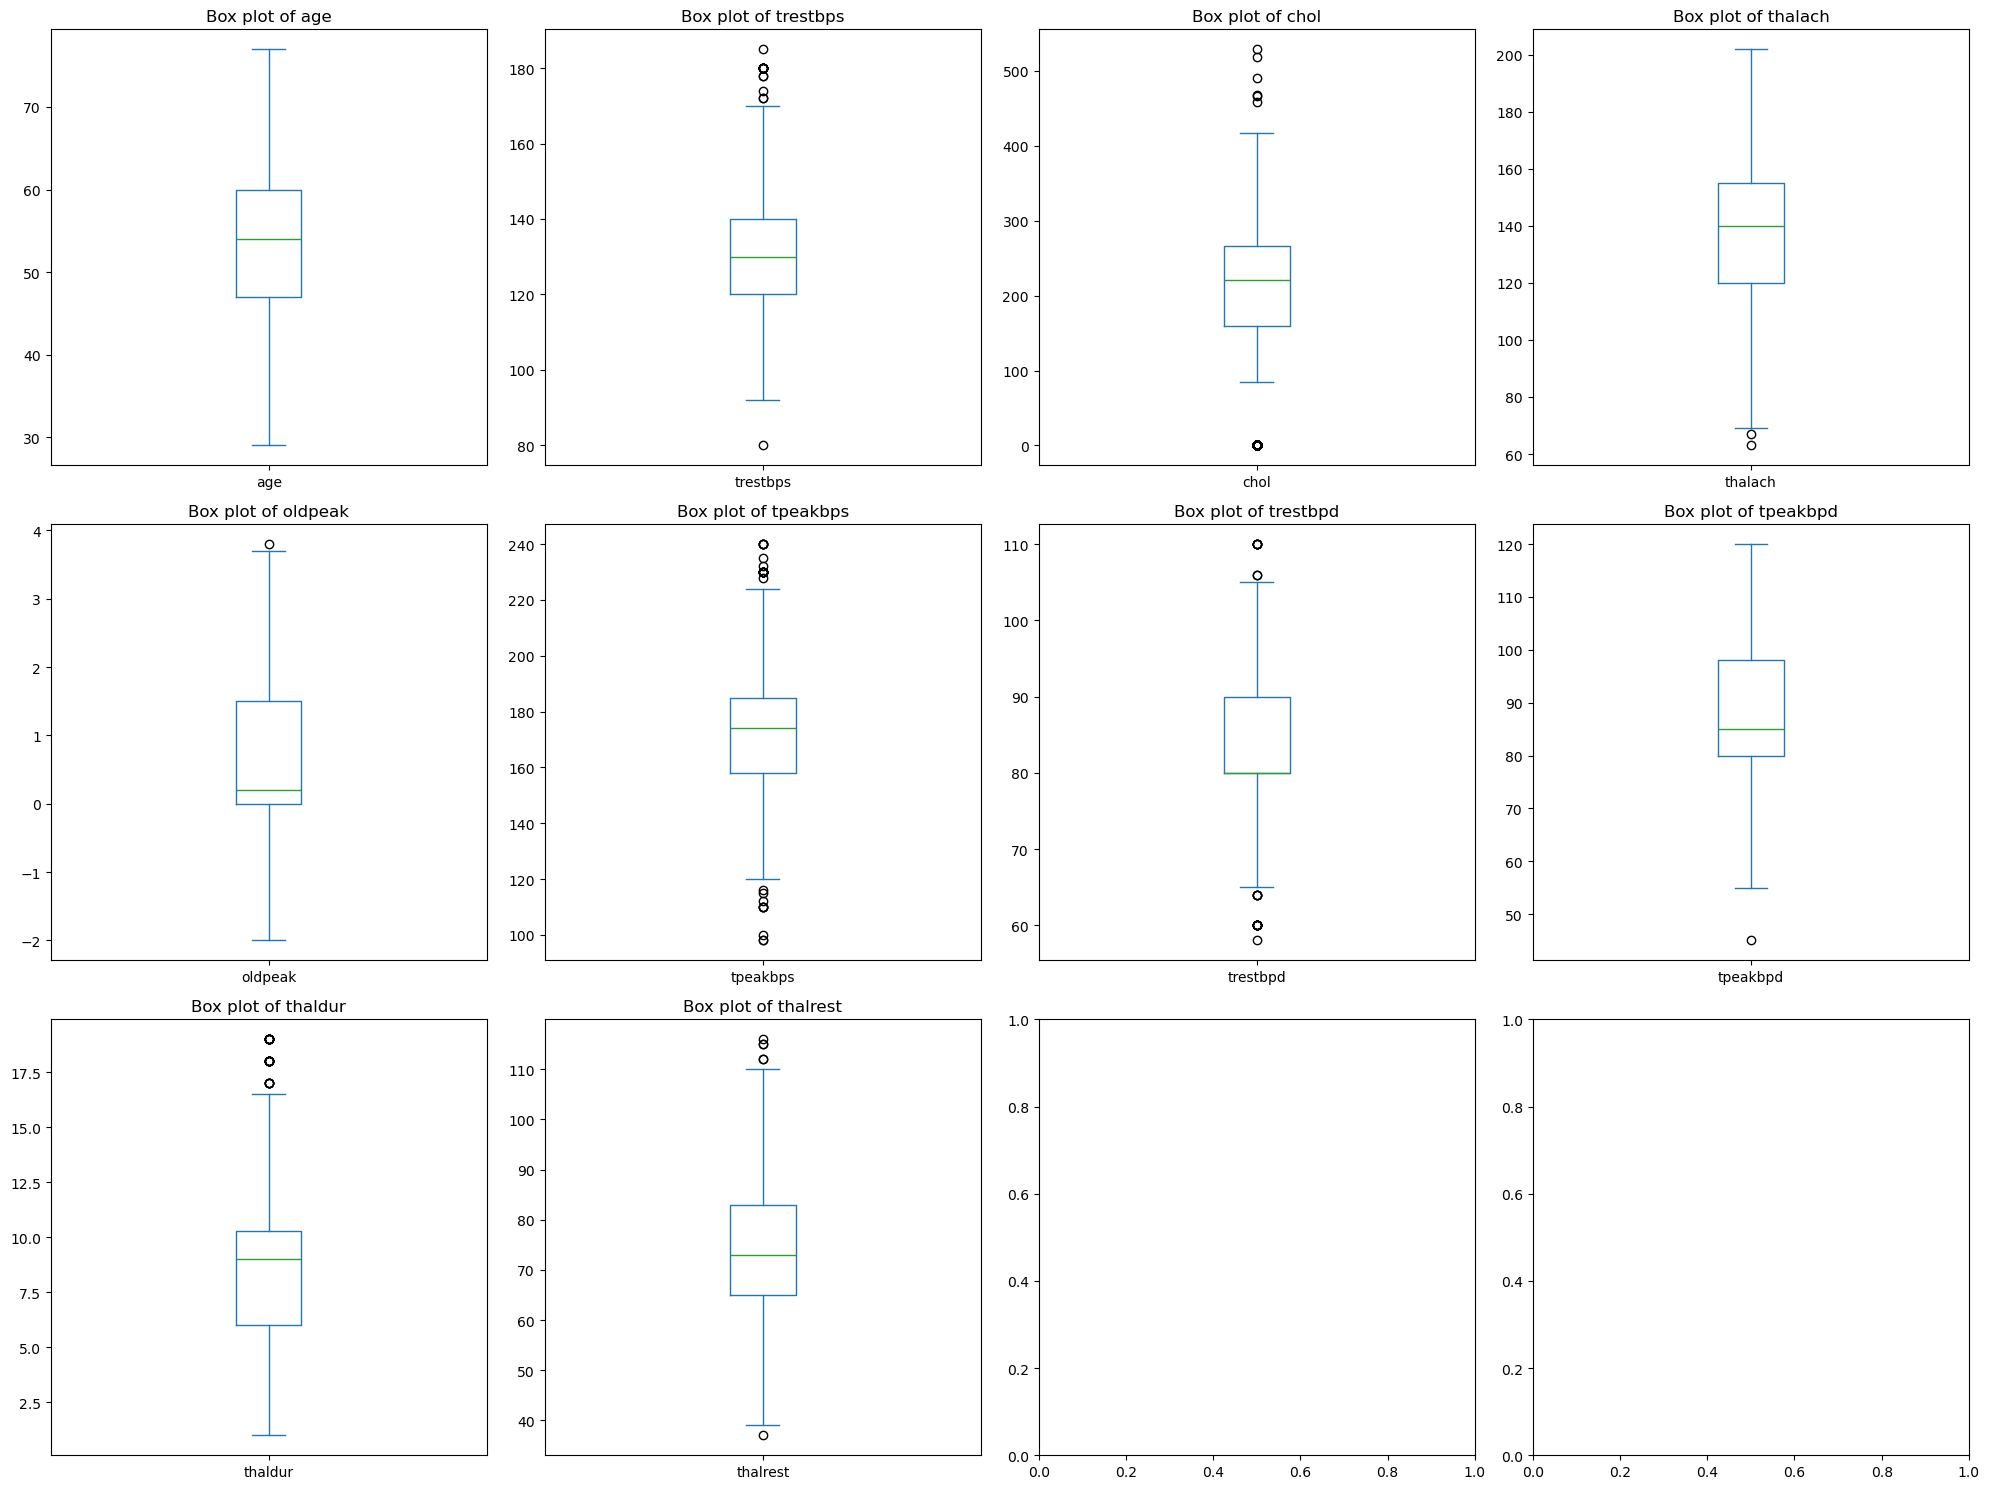

In [363]:
# Construct box plots on the numerical features
# Create a figure and axis
fig, ax = plt.subplots(3, 4, figsize=(20, 15))

# Flatten the axis for easy iteration
ax = ax.flatten()

# Plot box plots for each numerical feature
for i, feature in enumerate(numerical_features):
    data[feature].plot(kind='box', ax=ax[i])
    ax[i].set_title(f'Box plot of {feature}')
    
plt.tight_layout()
plt.show()

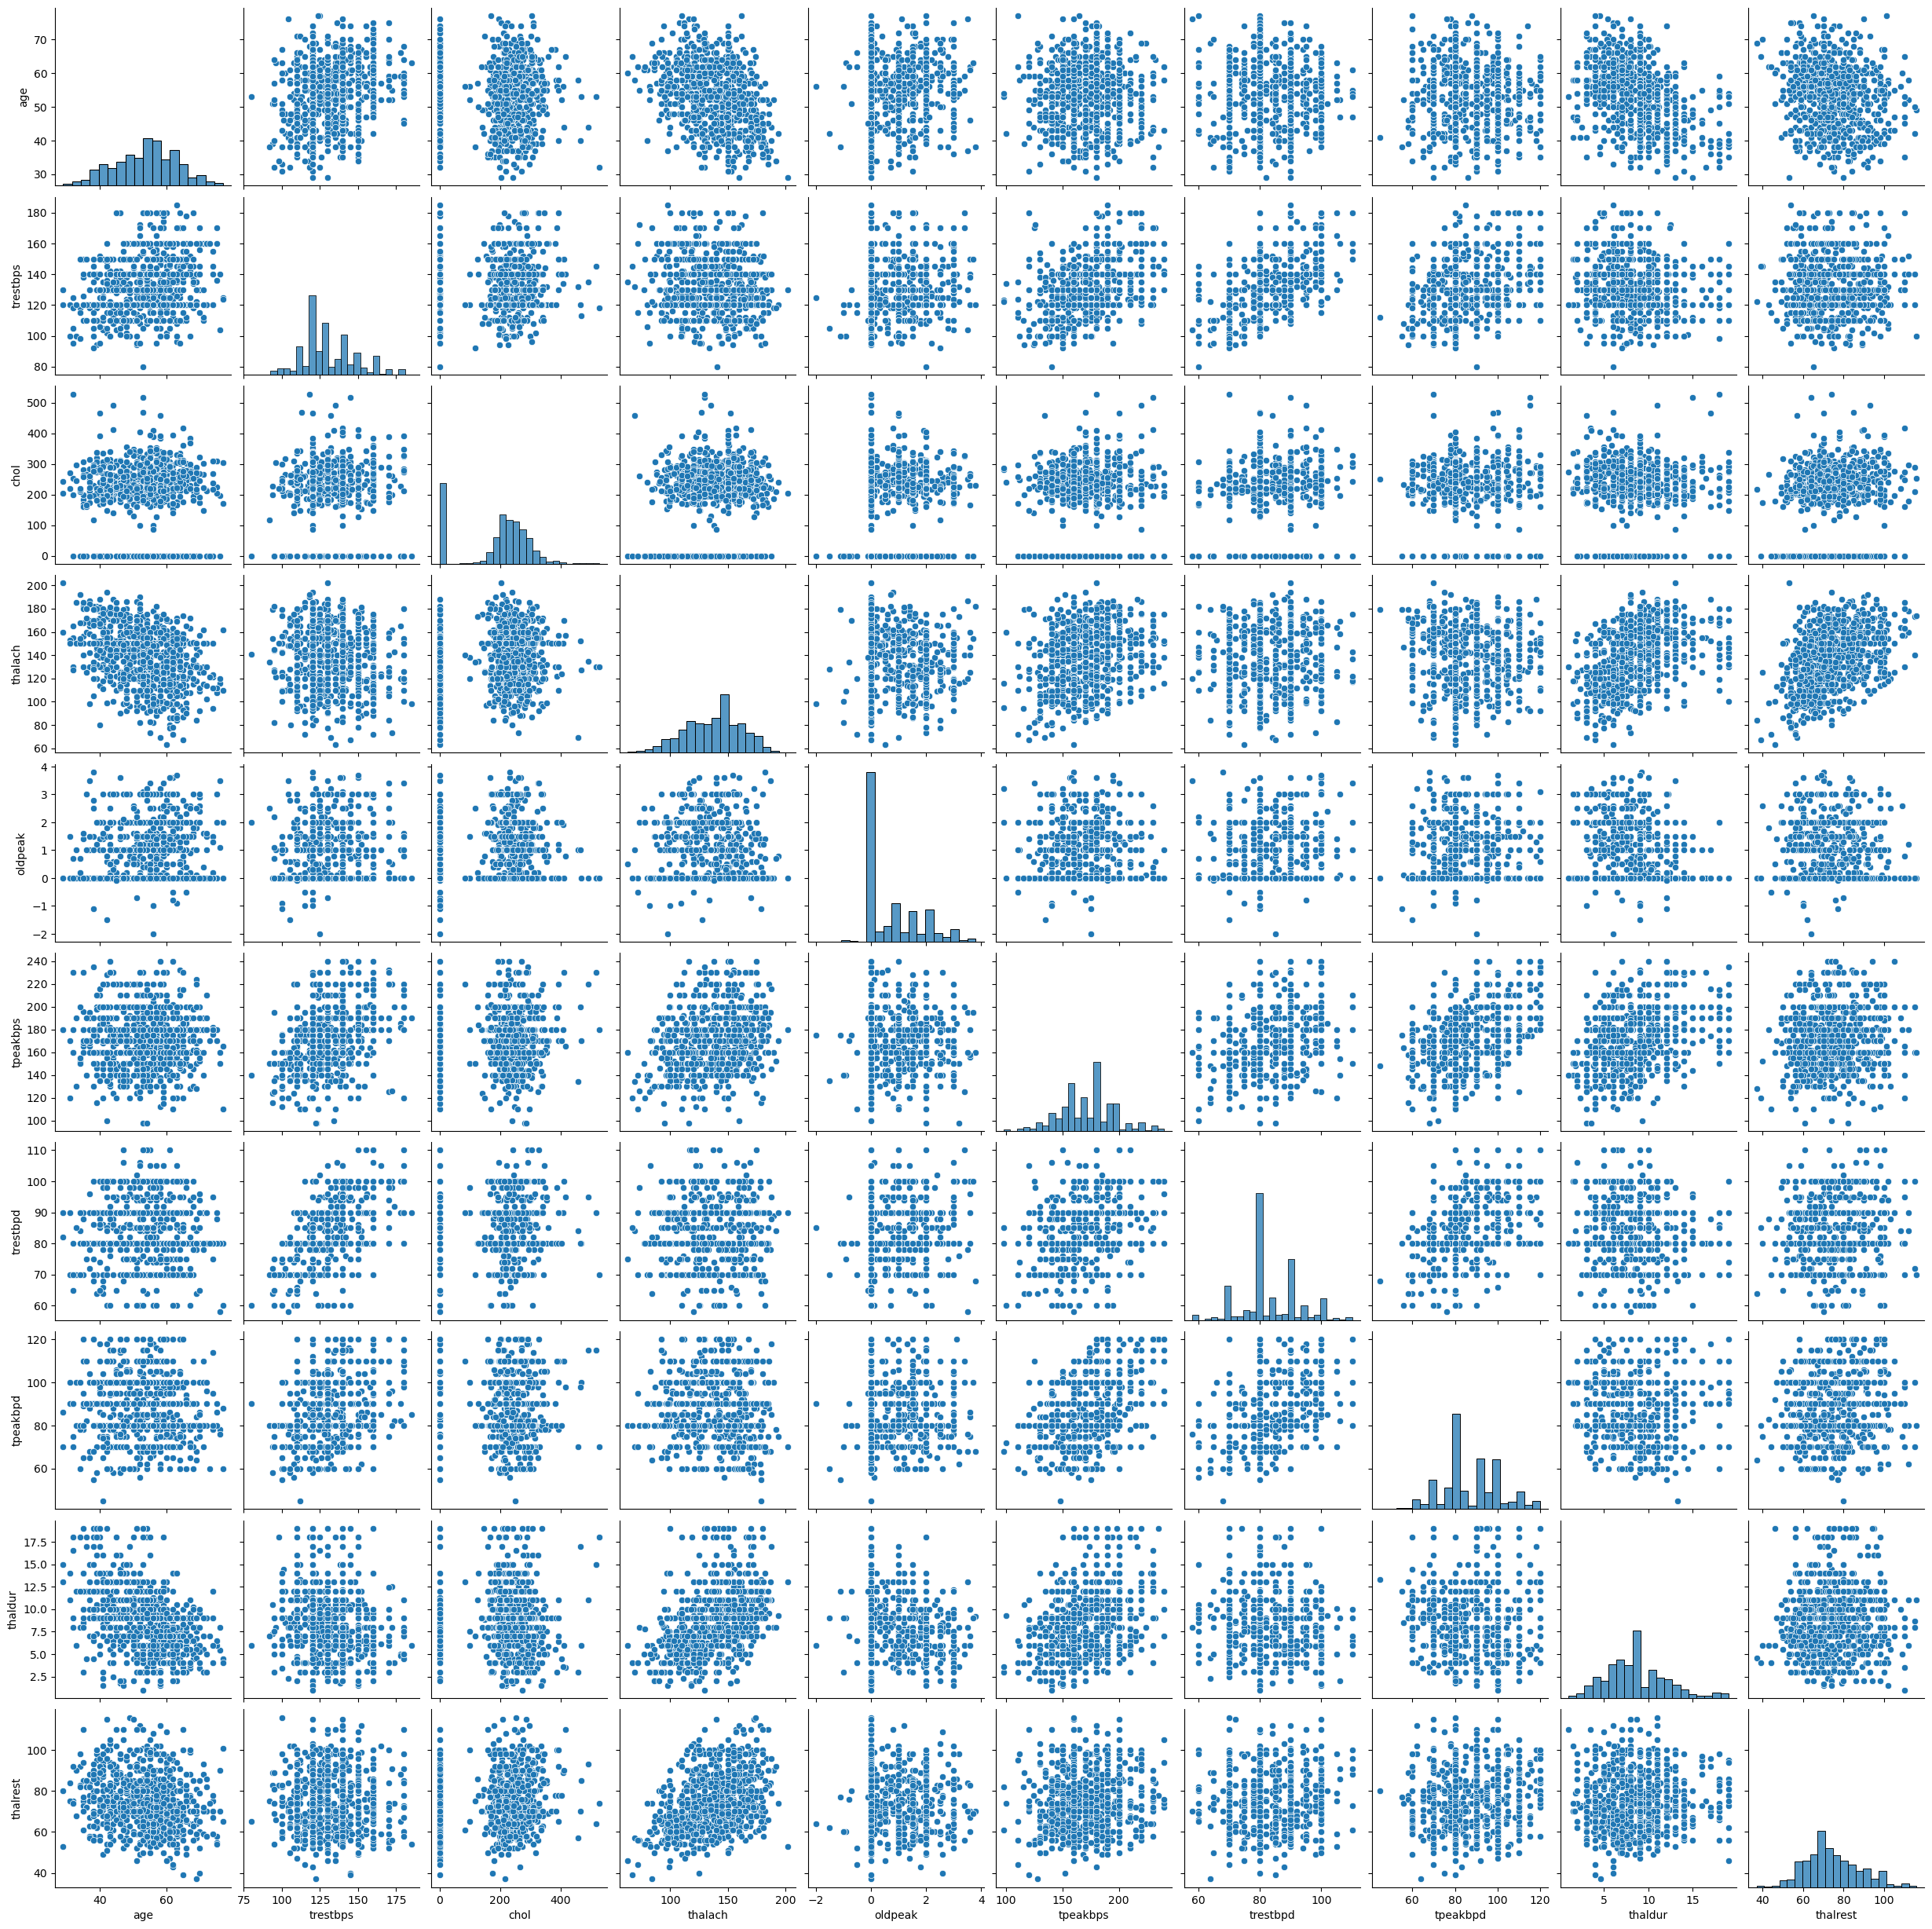

In [364]:
# Scatter plots using the numerical features to observe for correlation
sns.pairplot(data[numerical_features])

# Display the plots
plt.show()

## 4.1 Box Plots Discussion
From the generated box plots, it is clear that all extreme outliers have been cleared out, since a multiple of 3 standard deviations was used to filter the data points. For each box plot, it appears that the dataset is balanced, as there are no extremeties or a domination of a certain value. For example, there seems to be a even distribution of ages, meaning that the demographic which this dataset was sampled from is not biased towards any specific age group. Even after imputation of some NULL data, there are no visible skewness with any of the provided variables.

Overall, this dataset holistically represents all possible cases from this preliminary box plot. exploratory data analysis

## 4.2 Scatter Plots Discussion
Scatter plots can be observed to sanity check the dataset, including IID (independent, identically distributed) assumptions for later data analysis. Some data pairs that seem to exhibit notable correlation behavior are as follows:

1. Thalach Vs. Thalrest (Max Heart Rate Vs. Resting Heart Rate) - Positive Correlation
2. Thaldur Vs. Age (Duration of Exercise in Minutes Vs. Age) - Negative Correlation
3. Thaldur Vs. Thalach (Duration of Exercise Vs. Max Heart Rate) - Positve Correlation
4. Thaldur Vs. Tpeakbps (Duration of Exercise Vs. Peak Exercise Blood Pressure Part 1) - Positve Correlation
5. Thalach Vs. Age (Max Heart Rate Vs. Age) - Negative Correlation

These observations make sense. For example, as people age, usually they exercise less. Another example is the decrease in max heart rate as age increases. According to this [ScienceDaily article](https://www.sciencedaily.com/releases/2013/10/131014155744.htm#:~:text=A%20new%20study%20by%20a,the%20heart's%20natural%20pacemaker%2C%20the), "aging depresses the spontaneous electrical activity of the heart's natural pacemaker, the sinoatrial node".

The rest of the data also passes the common sense test. However, it is important to note that some of these could have correlation. For example, this [PubMed Article](https://pubmed.ncbi.nlm.nih.gov/10999646/#:~:text=Total%20cholesterol%20levels%20steadily%20increase,%5B240%20mg%2FdL%5D) states that cholestrol increases with age slightly from age 20 - 65, but it is as if they are independent given the scatter plot.

Since we only have around 800 - 900 data points, further data collection can help us zeroing on the quality of this dataset to draw a better conclusion.

In [365]:
# Save the cleaned data to a new table in the database
data.to_sql(name=table_name_cleaned, con=engine, if_exists='replace', index=False)

847